# Lunar Aging Workshop
In this workshop, we will compare the ages of two parts of the moon: the lunar highlands and the lunar maria. The lunar highlands are the light-colored areas on the moon, while the lunar maria are the dark-colored areas. We will use the concept of crater counting to determine the relative ages of the highlands and maria.

### Imports
Here, we import a few packages and load some data to make the code later run smoothly. Just run the cell below to get started!

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ipywidgets as widgets
from craterpy import CraterDatabase
from PIL import Image
from IPython.display import display

### The Moon
Below is an image of the full moon. Notice that although the Moon is a sphere, here we see it projected as a rectangle- similar to if you peeled an orange and laid the peel flat. The highlands are the light-colored areas, while the maria are the dark-colored areas.

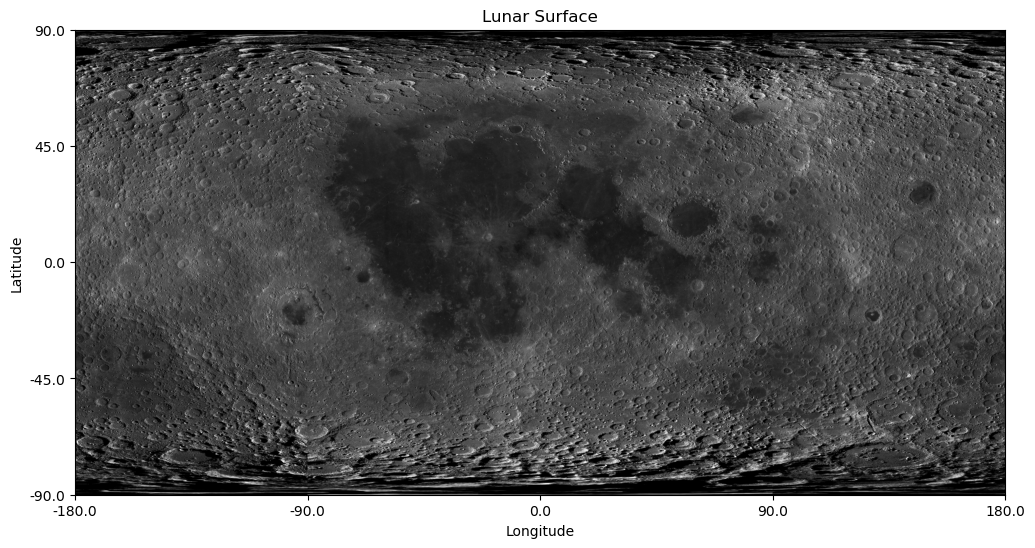

In [ ]:
# Load the image of the moon
full_moon_path = "./lunar_data/full_moon.tif"
full_moon = Image.open(full_moon_path)

# Plot the image
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Lunar Surface")

# Change the colormap of the image
colormap = "gray" # Try changing this "viridis", "inferno", "spring", "Purples", anything!
ax.imshow(full_moon, cmap=colormap)

# Label axes in latitudinal and longitudinal coordinates
min_lat, max_lat = -90, 90
min_lon, max_lon = -180, 180
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xticks(np.linspace(0, full_moon.width, 5))
ax.set_xticklabels(np.round(np.linspace(min_lon, max_lon, 5), decimals=0))
ax.set_yticks(np.linspace(0, full_moon.height, 5))
ax.set_yticklabels(np.round(np.linspace(max_lat, min_lat, 5), decimals=0))

plt.show()

### Crater Counting
Now, letʻs zoom in to a few specific areas on the moon. We will count the number of craters in each area to determine the relative ages of the highlands and maria. The highlands are older than the maria, so we expect the highlands to have more craters than the maria.

In [ ]:
'''
Change the below cells to interact with the code!
Try changing the area number and colormap values
'''
area_number = 8 # Try changing this number to 1, 2, 3, 4, 5, 6, 7, 8
colormap = "gray" # Try changing this "viridis", "inferno", "spring", "Purples", anything!

# Define available minimum diameter thresholds
min_diameters = [1, 5, 10, 50, 100]

# Load the data of a specific area
area_path = f"./lunar_data/area_{area_number}.tif"
area_lats_lons = pd.read_csv("./lunar_data/area_lats_lons.csv").iloc[area_number - 1]
min_lat, max_lat = area_lats_lons["lower_right_lat"], area_lats_lons["upper_left_lat"]
min_lon, max_lon = area_lats_lons["upper_left_lon"], area_lats_lons["lower_right_lon"]
craters = pd.read_csv("./lunar_data/reduced_crater_database.csv")
area_craters = craters.loc[(craters.LAT_CIRC_IMG > min_lat) & (craters.LAT_CIRC_IMG < max_lat) & (craters.LON_CIRC_IMG > min_lon) & (craters.LON_CIRC_IMG < max_lon)]

def update_plot(min_diameter, area_path, colormap, area_craters):
    area_craters = area_craters.loc[(area_craters.DIAM_CIRC_IMG > min_diameter)]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8)) 

    # Plot the image with craters
    if not area_craters.empty:
        area_crater_counts = CraterDatabase(area_craters, units="km")
        area_crater_counts.add_annuli(0, 1, 'crater')
        ax = area_crater_counts.plot(ax=ax, lw=0.75, alpha=1, color='tab:red')

    # Plot the image of the area
    im = plt.imread(area_path)
    ax.set_title(f"Lunar Surface of Area {area_number}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    if (min_lon > 180) & (max_lon > 180):
        ax.imshow(im, extent=[min_lon - 360, max_lon - 360, min_lat, max_lat], cmap=colormap)
    else:
        ax.imshow(im, extent=[min_lon, max_lon, min_lat, max_lat], cmap=colormap)
    plt.show()
    
# Create the interactive slider
style = {'description_width': 'initial'}
slider = widgets.SelectionSlider(
    options=min_diameters,
    value=10,
    description="Minimum Crater Diameter",
    continuous_update=False,
    layout=widgets.Layout(width='1000px', height='50px'),
    style=style
)

# Display the interactive plot
interactive_plot = widgets.interactive(update_plot, min_diameter=slider, area_path=widgets.fixed(area_path), colormap=widgets.fixed(colormap), area_craters=widgets.fixed(area_craters))
display(interactive_plot)

interactive(children=(SelectionSlider(continuous_update=False, description='Minimum Crater Diameter', index=2,…

In [ ]:
# Have them enter these numbers into a list for different diameter sizes, then have the computer print out the exact number

### Age Calculation
Now, we will use the number of craters of different diameter sizes to date the areas we examined above.

In [ ]:
# TODO: Show the age line image. Overlay the dots for the crater counts students calculated above on the image, and have students predict what age the surface is
# Does it match student intution that the mare is younger than the highlands?